# **MACHINE LEARNING PROJECT**

**TOPIC  -  MOVIE RECOMMENDATION SYSTEM**

---



GROUP MEMBERS


1. KOMAL PATLE - B2/28

2. ADARSH MISHRA - B2/29

# 1) By Cosine similarity algorithm

Importing the dependencies

In [1]:
import numpy as np
import pandas as pd
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, classification_report

Loading the dataset

In [ ]:
# loading the data from the csv file to a pandas dataframe

movies_data = pd.read_csv('/content/moviesCosSim.csv')

In [ ]:
# printing the first 5 rows of the dataframe

movies_data.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [ ]:
# no. of rows and columns in the dataframe

movies_data.shape

(4803, 24)

Data cleaning and formatting

In [ ]:
# selecting the most relevent features for recommendation

selected_features = ['genres', 'keywords', 'tagline', 'cast', 'director']
print(selected_features)

['genres', 'keywords', 'tagline', 'cast', 'director']


In [ ]:
# replacing the null values with null strings

for feature in selected_features:
  movies_data[feature] = movies_data[feature].fillna('')

EDA

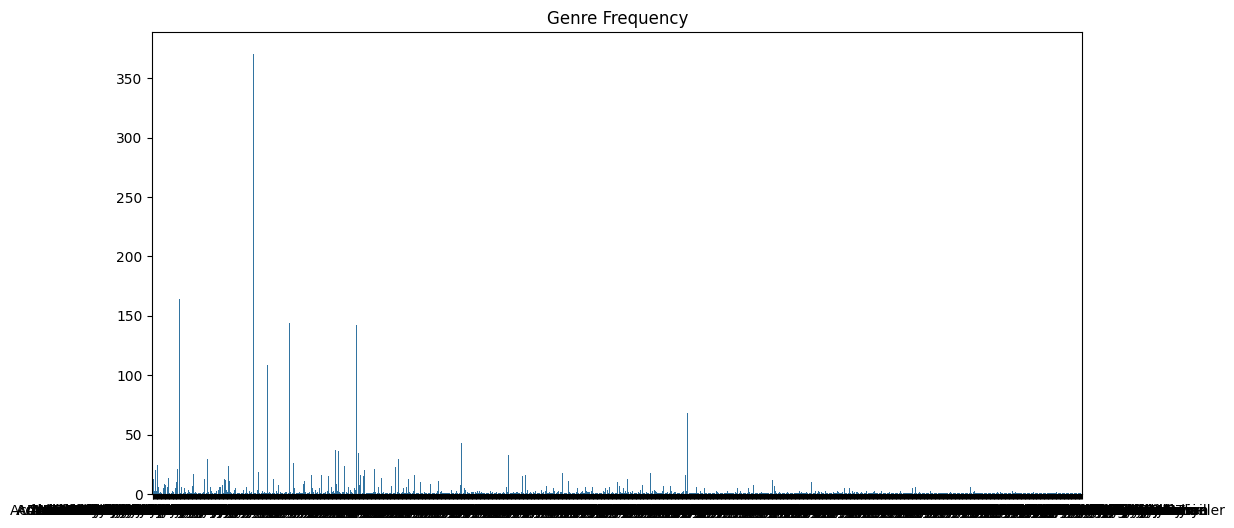

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Visualizing the most common genres
genres = movies_data['genres'].str.split('|').explode()
genre_counts = Counter(genres)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.title("Genre Frequency")
plt.show()

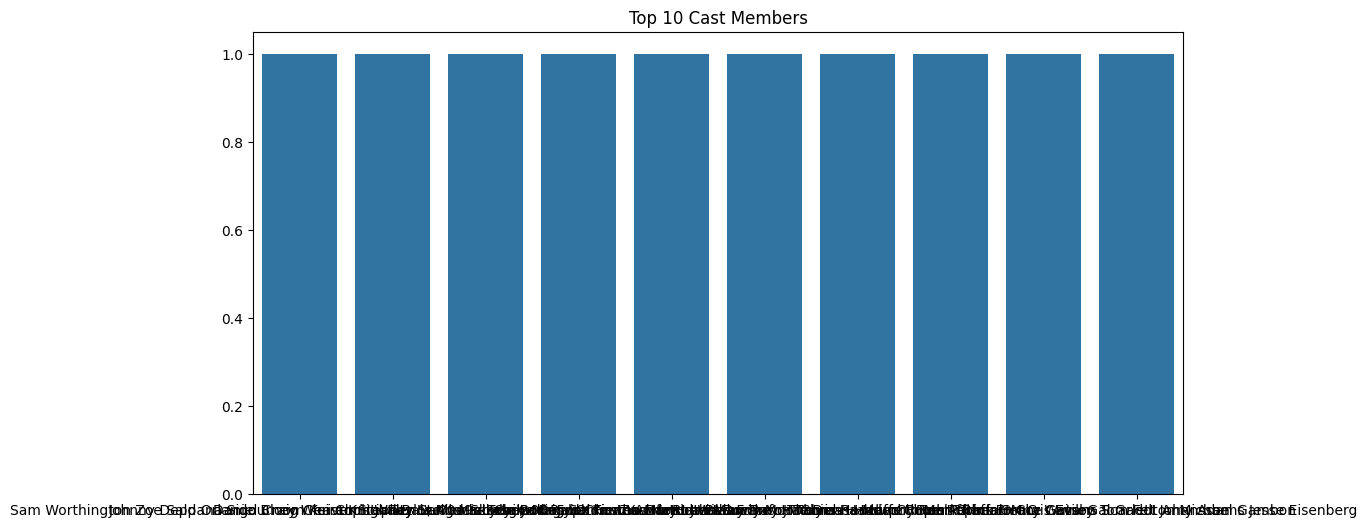

In [ ]:
# Exploring popular cast members
cast_members = movies_data['cast'].str.split('|').explode()
cast_counts = Counter(cast_members)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(cast_counts.keys())[:10], y=list(cast_counts.values())[:10])
plt.title("Top 10 Cast Members")
plt.show()

Feature engineering and selection

In [ ]:
# combining all the 5 selected features

combined_features = movies_data['genres'] + ' ' + movies_data['keywords'] + ' ' + movies_data['tagline'] + ' ' + movies_data['cast'] + ' ' + movies_data['director']
print(combined_features)

0       Action Adventure Fantasy Science Fiction cultu...
1       Adventure Fantasy Action ocean drug abuse exot...
2       Action Adventure Crime spy based on novel secr...
3       Action Crime Drama Thriller dc comics crime fi...
4       Action Adventure Science Fiction based on nove...
                              ...                        
4798    Action Crime Thriller united states\u2013mexic...
4799    Comedy Romance  A newlywed couple's honeymoon ...
4800    Comedy Drama Romance TV Movie date love at fir...
4801      A New Yorker in Shanghai Daniel Henney Eliza...
4802    Documentary obsession camcorder crush dream gi...
Length: 4803, dtype: object


**Train and Test the Model with Cross-Validation** :- Cosine similarity doesn’t require a traditional training and testing split.

In [ ]:
# converting the text data to feature vectors

vectorizer = TfidfVectorizer()

In [ ]:
feature_vectors = vectorizer.fit_transform(combined_features)

print(feature_vectors)

  (0, 201)	0.07860022416510505
  (0, 274)	0.09021200873707368
  (0, 5274)	0.11108562744414445
  (0, 13599)	0.1036413987316636
  (0, 5437)	0.1036413987316636
  (0, 3678)	0.21392179219912877
  (0, 3065)	0.22208377802661425
  (0, 5836)	0.1646750903586285
  (0, 14378)	0.33962752210959823
  (0, 16587)	0.12549432354918996
  (0, 3225)	0.24960162956997736
  (0, 14271)	0.21392179219912877
  (0, 4945)	0.24025852494110758
  (0, 15261)	0.07095833561276566
  (0, 16998)	0.1282126322850579
  (0, 11192)	0.09049319826481456
  (0, 11503)	0.27211310056983656
  (0, 13349)	0.15021264094167086
  (0, 17007)	0.23643326319898797
  (0, 17290)	0.20197912553916567
  (0, 13319)	0.2177470539412484
  (0, 14064)	0.20596090415084142
  (0, 16668)	0.19843263965100372
  (0, 14608)	0.15150672398763912
  (0, 8756)	0.22709015857011816
  :	:
  (4801, 403)	0.17727585190343229
  (4801, 4835)	0.24713765026964
  (4801, 17266)	0.28860981849329476
  (4801, 13835)	0.27870029291200094
  (4801, 13175)	0.28860981849329476
  (4801, 171

Cosine Similarity

In [ ]:
# getting the similarity score using cosine similarity

similarity = cosine_similarity(feature_vectors)

print(similarity)

[[1.         0.07219487 0.037733   ... 0.         0.         0.        ]
 [0.07219487 1.         0.03281499 ... 0.03575545 0.         0.        ]
 [0.037733   0.03281499 1.         ... 0.         0.05389661 0.        ]
 ...
 [0.         0.03575545 0.         ... 1.         0.         0.02651502]
 [0.         0.         0.05389661 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.02651502 0.         1.        ]]


In [ ]:
similarity.shape

(4803, 4803)

Taking user input

In [ ]:
# getting the movie name from the user

movie_name = input(' Enter you favourite movie name : ')

 Enter you favourite movie name : avatar


In [ ]:
# creating a list with all the movie names in the dataset

list_of_all_titles = movies_data['title'].tolist()

print(list_of_all_titles)

['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre', 'The Dark Knight Rises', 'John Carter', 'Spider-Man 3', 'Tangled', 'Avengers: Age of Ultron', 'Harry Potter and the Half-Blood Prince', 'Batman v Superman: Dawn of Justice', 'Superman Returns', 'Quantum of Solace', "Pirates of the Caribbean: Dead Man's Chest", 'The Lone Ranger', 'Man of Steel', 'The Chronicles of Narnia: Prince Caspian', 'The Avengers', 'Pirates of the Caribbean: On Stranger Tides', 'Men in Black 3', 'The Hobbit: The Battle of the Five Armies', 'The Amazing Spider-Man', 'Robin Hood', 'The Hobbit: The Desolation of Smaug', 'The Golden Compass', 'King Kong', 'Titanic', 'Captain America: Civil War', 'Battleship', 'Jurassic World', 'Skyfall', 'Spider-Man 2', 'Iron Man 3', 'Alice in Wonderland', 'X-Men: The Last Stand', 'Monsters University', 'Transformers: Revenge of the Fallen', 'Transformers: Age of Extinction', 'Oz: The Great and Powerful', 'The Amazing Spider-Man 2', 'TRON: Legacy', 'Cars 2', 'Green Lant

In [ ]:
# finding the close match for the movie name given by the user

find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)

print(find_close_match)

['Avatar']


In [ ]:
close_match = find_close_match[0]

print(close_match)

Avatar


In [ ]:
# finding the index of the movie with title

index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]

print(index_of_the_movie)

0


In [ ]:
# getting a list of similar movies

similarity_score = list(enumerate(similarity[index_of_the_movie]))

print(similarity_score)

[(0, 1.0), (1, 0.07219486822992488), (2, 0.037732999577179294), (3, 0.012520204623868908), (4, 0.10702574467235304), (5, 0.07786899789424222), (6, 0.008237143013608844), (7, 0.03613473061484885), (8, 0.02960930964063025), (9, 0.026287167439951735), (10, 0.09261074046755373), (11, 0.012717759249124133), (12, 0.02721736008310012), (13, 0.029569752523347516), (14, 0.06915925473724743), (15, 0.019551594499309027), (16, 0.034263405780616416), (17, 0.02603656461429414), (18, 0.05714759266672412), (19, 0.0389505953521203), (20, 0.03971480215415496), (21, 0.01201480380565613), (22, 0.030438694261989592), (23, 0.045926535588179496), (24, 0.04623989017965258), (25, 0.04284926095950226), (26, 0.07010711150614288), (27, 0.037198076232328854), (28, 0.04083909796927843), (29, 0.03858648330156398), (30, 0.07893753610792024), (31, 0.06055522138055148), (32, 0.030362745635800832), (33, 0.03591021470068869), (34, 0.0), (35, 0.037696741034748446), (36, 0.04891087950911421), (37, 0.08575173998419439), (38

In [ ]:
len(similarity_score)

4803

In [ ]:
# sorting the movies based on their similarity score

sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True)

print(sorted_similar_movies)

[(0, 1.0), (3158, 0.2494676630753241), (2403, 0.24841462595906272), (94, 0.24505931974059822), (56, 0.20378069648285427), (47, 0.20115287461144912), (1053, 0.19702752258651424), (838, 0.18017023369312363), (3730, 0.1764624118531341), (4593, 0.17448845797415172), (239, 0.17441748680810656), (1531, 0.1682605817219649), (2696, 0.1650346025917652), (812, 0.16062301907491794), (643, 0.15644455512484967), (4401, 0.15468923545220403), (2198, 0.15217161971893786), (770, 0.1502572672775349), (1951, 0.14933372705282924), (2229, 0.14661801285492254), (1922, 0.14481974301913123), (206, 0.14226144606175548), (3208, 0.1401230206493547), (1759, 0.13899056016968867), (43, 0.1348209130228474), (1473, 0.13476547670086914), (278, 0.13291021545504), (158, 0.1325289213162767), (1650, 0.13024318650645417), (1275, 0.1260221630479115), (3439, 0.12480340331169379), (661, 0.12153002734138184), (3202, 0.12144749322246055), (4332, 0.12002556168548509), (3105, 0.11948466494212537), (775, 0.11847062758014923), (109

Output (recommendations)

In [ ]:
# print the name of the similar movie based on the index

print(' Movies suggested for you : \n ')

i = 1

for movies in sorted_similar_movies:
  index = movies[0]
  title_from_index = movies_data[movies_data.index==index]['title'].values[0]
  if(i < 10):
    print(i, '.' , title_from_index)
    i += 1

 Movies suggested for you : 
 
1 . Avatar
2 . Alien
3 . Aliens
4 . Guardians of the Galaxy
5 . Star Trek Beyond
6 . Star Trek Into Darkness
7 . Galaxy Quest
8 . Alien³
9 . Cargo


In [ ]:
# Sample ground truth liked movies (replace with actual liked titles)
liked_movies = ['Alien', 'Guardians of the Galaxy', 'Galaxy Quest']  # Adjust this list as needed


In [ ]:
# Getting recommended movie titles
recommended_movies = [movies_data[movies_data.index == movies[0]]['title'].values[0] for movies in sorted_similar_movies[:10]]

# Create binary lists for true labels and predictions
y_true = [1 if movie in liked_movies else 0 for movie in recommended_movies]  # 1 for liked, 0 for not liked
y_pred = [1] * len(recommended_movies)  # assuming all recommended are predicted as liked


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate accuracy, precision, recall, specificity, F1 score
TP = cm[1, 1] if len(cm) > 1 and len(cm[1]) > 1 else 0
TN = cm[0, 0] if len(cm) > 1 and len(cm[0]) > 0 else 0
FP = cm[0, 1] if len(cm) > 1 and len(cm[0]) > 1 else 0
FN = cm[1, 0] if len(cm) > 1 and len(cm[1]) > 0 else 0

accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)
print("F1 Score:", f1_score)


Confusion Matrix:
 [[0 7]
 [0 3]]
Accuracy: 0.3
Precision: 0.3
Recall: 1.0
Specificity: 0.0
F1 Score: 0.4615384615384615


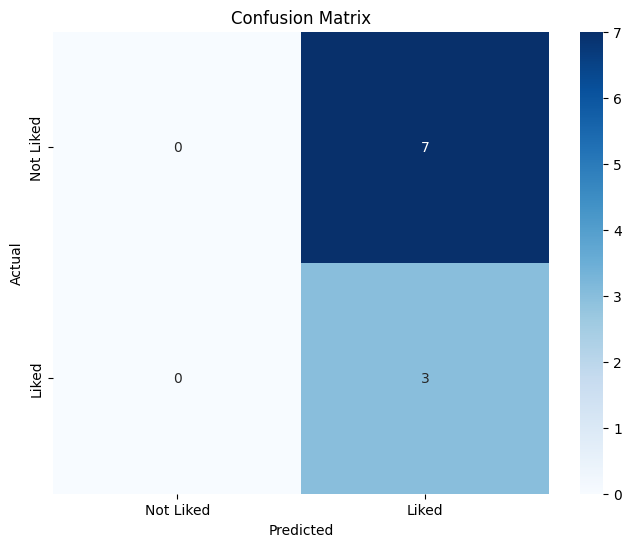

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# 2) By K nearest neighbors algorithm

Loading the datasets

In [ ]:
movies='/content/movies.csv'
ratings='/content/ratings.csv'

df_movies=pd.read_csv(movies, usecols=['movieId','title'], dtype={'movieId':'int32','title':'str'})
df_ratings=pd.read_csv(ratings, usecols=['userId','movieId','rating'],dtype={'userId':'int32','movieId':'int32','rating':'float32'})

Data cleaning and formatting

In [ ]:
movies_users=df_ratings.pivot(index='movieId', columns='userId',values='rating').fillna(0)
mat_movies_users=csr_matrix(movies_users.values)

EDA

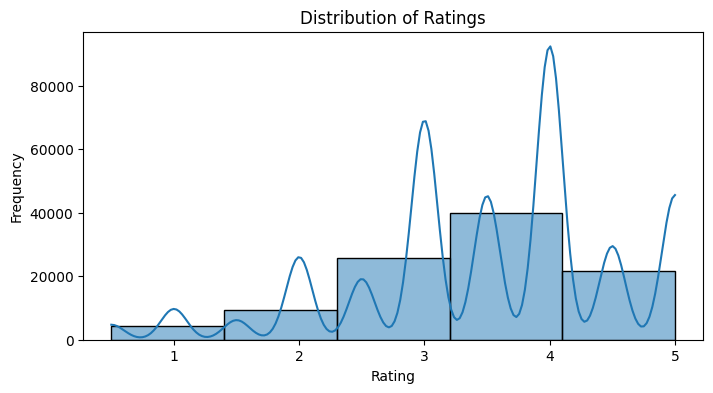

In [ ]:
# PlotTING distribution of ratings
plt.figure(figsize=(8, 4))
sns.histplot(df_ratings['rating'], kde=True, bins=5)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


<ipython-input-64-e3e55ff0f8bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_rated_movie_titles['rating_count'] = top_rated_movies.values


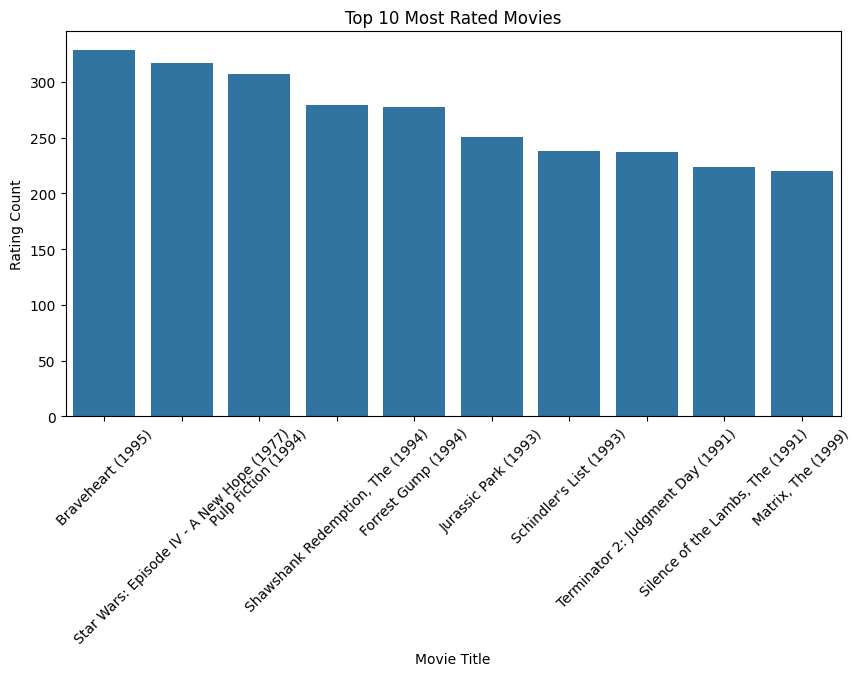

In [ ]:
# CalculatING the most rated movies (by count of ratings)
top_rated_movies = df_ratings['movieId'].value_counts().head(10)
top_rated_movie_titles = df_movies[df_movies['movieId'].isin(top_rated_movies.index)]
top_rated_movie_titles['rating_count'] = top_rated_movies.values

# PlotTING the most rated movies
plt.figure(figsize=(10, 5))
sns.barplot(data=top_rated_movie_titles, x='title', y='rating_count')
plt.xticks(rotation=45)
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Movie Title")
plt.ylabel("Rating Count")
plt.show()

Feature engineering

In [ ]:
# Creating user-item matrix
movies_users = df_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# Normalizing the user ratings to center each user's ratings around zero
user_ratings_mean = movies_users.mean(axis=1)
movies_users_centered = movies_users.sub(user_ratings_mean, axis=0)
mat_movies_users = csr_matrix(movies_users_centered.values)  # Convert to sparse matrix for efficiency


Train and Test the Model with Cross-Validation

In [ ]:
# Initializing and training the KNN model with cosine similarity
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)

In [ ]:
model_knn.fit(mat_movies_users)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [ ]:
pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import process

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
def recommender(movie_name, data, model, n_recommendations, threshold):
    idx = process.extractOne(movie_name, df_movies['title'])[2]
    print('Movie Selected: ', df_movies['title'][idx], 'Index: ', idx)
    print('Searching for recommendations.....')

    distances, indices = model.kneighbors(data[idx], n_neighbors=n_recommendations)

    recommended_movies = df_movies['title'].iloc[indices.flatten()]
    print('Recommended Movies:')
    print(recommended_movies)

    # Generate predictions and ground truth for evaluation
    y_true = []
    y_pred = []

    for movie_idx in indices.flatten():
        actual_ratings = df_ratings[df_ratings['movieId'] == movies_users.index[movie_idx]]
        for _, row in actual_ratings.iterrows():
            y_true.append(1 if row['rating'] >= threshold else 0)
            y_pred.append(1 if df_movies['title'][movie_idx] in recommended_movies.values else 0)

    return y_true, y_pred


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


Movie Selected:  Captain America (1990) Index:  5570
Searching for recommendations.....
Recommended Movies:
9463                                         Logan (2017)
9470                                 The Boss Baby (2017)
6105                           Grand Theft Parsons (2003)
9099                              Er ist wieder da (2015)
9465                             T2: Trainspotting (2017)
3422    Scenes from the Class Struggle in Beverly Hill...
416                                Jimmy Hollywood (1994)
9462                                       Get Out (2017)
6181                             Benchwarmers, The (2006)
8642                         Corner Gas: The Movie (2014)
6197                                   Kinky Boots (2005)
6212                                          Cars (2006)
6220                        Devil Wears Prada, The (2006)
9455          Dana Carvey: Straight White Male, 60 (2016)
6224                             Lady in the Water (2006)
8639                  

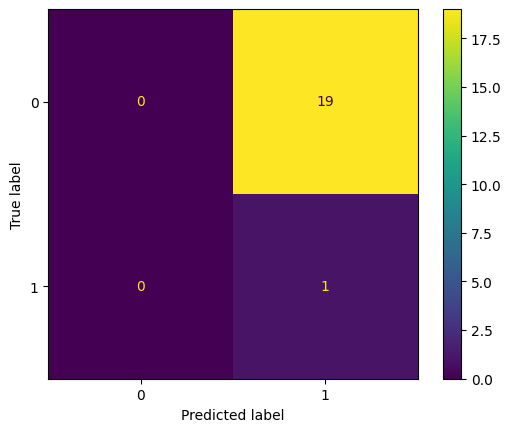

In [ ]:
# Setting the threshold for what is considered a positive recommendation
threshold = 3.5
y_true, y_pred = recommender('captain america', mat_movies_users, model_knn, 20, threshold)

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display metrics
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Plot Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()


# 3) By apriori algorithm

Loading the dataset

In [2]:
ratings_df = pd.read_csv('/content/ratings_small.csv')
movies_df = pd.read_csv('/content/movies_metadata.csv', low_memory=False)

In [3]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


EDA

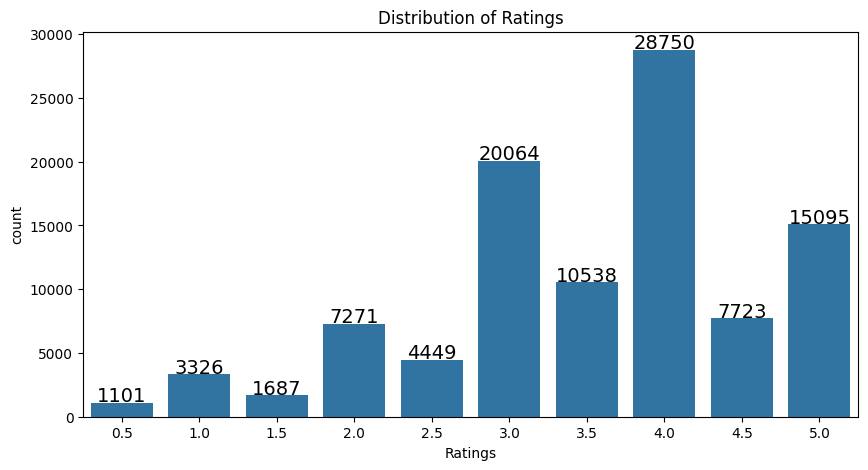

In [5]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=ratings_df, x='rating')
labels = (ratings_df['rating'].value_counts().sort_index())
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')

for i,v in enumerate(labels):
    ax.text(i, v+100, str(v), horizontalalignment='center', size=14, color='black')
plt.show()

Data cleaning and formatting

In [6]:
title_mask = movies_df['title'].isna()

In [7]:
movies_df = movies_df.loc[title_mask == False]

In [8]:
movies_df = movies_df.astype({'id': 'int64'})

In [9]:
df = pd.merge(ratings_df, movies_df[['id', 'title']], left_on='movieId', right_on='id')
df.head()

,userId,movieId,rating,timestamp,id,title
0,1,1371,2.5,1260759135,1371,Rocky III
1,1,1405,1.0,1260759203,1405,Greed
2,1,2105,4.0,1260759139,2105,American Pie
3,1,2193,2.0,1260759198,2193,My Tutor
4,1,2294,2.0,1260759108,2294,Jay and Silent Bob Strike Back


In [10]:
# Create true ratings DataFrame
true_ratings = ratings_df[['userId', 'movieId', 'rating']].copy()
true_ratings = true_ratings.rename(columns={'movieId': 'id'})


In [11]:
df.drop(['timestamp', 'id'], axis=1, inplace=True)

In [12]:
df = df.drop_duplicates(['userId','title'])

In [13]:
df_pivot = df.pivot(index='userId', columns='title', values='rating').fillna(0)

In [14]:
df_pivot = df_pivot.astype('int64')

In [15]:
# Function to encode ratings
def encode_ratings(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

# Apply encoding using apply and lambda
df_pivot = df_pivot.apply(lambda col: col.map(encode_ratings))

# Generate binary predictions from df_pivot
df_predictions = df_pivot.copy()
df_predictions[df_predictions > 0] = 1  # Convert ratings to binary predictions
df_predictions[df_predictions <= 0] = 0


Train the model

In [16]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

# Assuming you have df_pivot from your previous steps
# Convert the pivot DataFrame into a list of transactions
transactions = []
for user in df_pivot.index:
    user_ratings = df_pivot.loc[user]
    # Get titles of movies the user has rated with a rating of 1
    liked_movies = user_ratings[user_ratings >= 1].index.tolist()
    transactions.append(liked_movies)

# Use TransactionEncoder to convert transaction list to a DataFrame
encoder = TransactionEncoder()
encoded_array = encoder.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(encoded_array, columns=encoder.columns_)

# Now use the apriori function on the encoded DataFrame
frequent_itemset = apriori(df_encoded, min_support=0.07, use_colnames=True)

# Display the results
print(frequent_itemset)


        support                                           itemsets
0      0.129657                     (20,000 Leagues Under the Sea)
1      0.129657                            (2001: A Space Odyssey)
2      0.298063                                          (48 Hrs.)
3      0.292101                                      (5 Card Stud)
4      0.093890                          (A Brief History of Time)
...         ...                                                ...
91003  0.071535  (Terminator 3: Rise of the Machines, Three Col...
91004  0.073025  (Terminator 3: Rise of the Machines, Sissi, So...
91005  0.071535  (Terminator 3: Rise of the Machines, Three Col...
91006  0.071535  (Terminator 3: Rise of the Machines, Three Col...
91007  0.070045  (Terminator 3: Rise of the Machines, Reservoir...

[91008 rows x 2 columns]


In [17]:
frequent_itemset.head()

,support,itemsets
0,0.129657,"(20,000 Leagues Under the Sea)"
1,0.129657,(2001: A Space Odyssey)
2,0.298063,(48 Hrs.)
3,0.292101,(5 Card Stud)
4,0.093890,(A Brief History of Time)


In [18]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemset, metric="lift", min_threshold=1)

In [19]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(48 Hrs.),"(20,000 Leagues Under the Sea)",0.298063,0.129657,0.076006,0.255000,1.966724,0.037360,1.168245,0.700262
1,"(20,000 Leagues Under the Sea)",(48 Hrs.),0.129657,0.298063,0.076006,0.586207,1.966724,0.037360,1.696349,0.564766
2,"(20,000 Leagues Under the Sea)",(A Nightmare on Elm Street),0.129657,0.266766,0.081967,0.632184,2.369807,0.047379,1.993480,0.664134
3,(A Nightmare on Elm Street),"(20,000 Leagues Under the Sea)",0.266766,0.129657,0.081967,0.307263,2.369807,0.047379,1.256382,0.788322
4,"(20,000 Leagues Under the Sea)",(Back to the Future Part II),0.129657,0.210134,0.077496,0.597701,2.844379,0.050251,1.963381,0.745028


Interpret the result

In [20]:
df_res = rules.sort_values(by=['lift'], ascending=False)
df_res.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
70960,(On Guard),"(Muxmäuschenstill, The Garden of Eden)",0.087928,0.099851,0.070045,0.796610,7.977991,0.061265,4.425733,0.958976
70957,"(Muxmäuschenstill, The Garden of Eden)",(On Guard),0.099851,0.087928,0.070045,0.701493,7.977991,0.061265,3.055440,0.971678
197233,"(Rope, Big Fish)","(All the Way Boys, Psycho)",0.092399,0.095380,0.070045,0.758065,7.947833,0.061232,3.739096,0.963176
197236,"(All the Way Boys, Psycho)","(Rope, Big Fish)",0.095380,0.092399,0.070045,0.734375,7.947833,0.061232,3.416849,0.966350
2541148,"(48 Hrs., Cockles and Muscles, A Nightmare on ...","(Sissi, Monsoon Wedding, The Hours, Back to th...",0.093890,0.098361,0.071535,0.761905,7.746032,0.062300,3.786885,0.961143


In [21]:
df_MIB = df_res[df_res['antecedents'].apply(lambda x: len(x) ==1 and next(iter(x)) == 'Men in Black II')]

In [22]:
df_MIB = df_MIB[df_MIB['lift'] > 2]

In [23]:
df_MIB.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
63401,(Men in Black II),"(Nostalgia, Terminator 3: Rise of the Machines)",0.33383,0.080477,0.077496,0.232143,2.884590,0.050631,1.197518,0.980726
56669,(Men in Black II),"(Jarhead, Sleepless in Seattle)",0.33383,0.077496,0.073025,0.218750,2.822716,0.047155,1.180805,0.969319
380669,(Men in Black II),"(The Talented Mr. Ripley, Young and Innocent, ...",0.33383,0.080477,0.073025,0.218750,2.718171,0.046160,1.176990,0.948865
63407,(Men in Black II),"(Nostalgia, The 39 Steps)",0.33383,0.080477,0.073025,0.218750,2.718171,0.046160,1.176990,0.948865
1167108,(Men in Black II),"(Terminator 3: Rise of the Machines, Young and...",0.33383,0.080477,0.073025,0.218750,2.718171,0.046160,1.176990,0.948865


In [24]:
movies = df_MIB['consequents'].values

movie_list = []
for movie in movies:
    for title in movie:
        if title not in movie_list:
            movie_list.append(title)

In [25]:
movie_list[0:10]

['Nostalgia',
 'Terminator 3: Rise of the Machines',
 'Jarhead',
 'Sleepless in Seattle',
 'The Talented Mr. Ripley',
 'Young and Innocent',
 'Point Break',
 'The 39 Steps',
 'Once Were Warriors',
 'The Thomas Crown Affair']

In [27]:
# Merge `movies_df` with `true_ratings` to get the movie ID for each title
merged_df = true_ratings.merge(movies_df[['id', 'title']], left_on='id', right_on='id')


In [28]:
# Stack `df_predictions` and reset index to get userId and title as columns
df_predictions_stacked = df_predictions.stack().reset_index()
df_predictions_stacked.columns = ['userId', 'title', 'predicted_rating']


In [29]:
# Merge `merged_df` with `df_predictions_stacked` on `userId` and `title`
merged_df = merged_df.merge(df_predictions_stacked, on=['userId', 'title'])


In [30]:
# Binary classification: set `y_true` to 1 if actual rating is >= 1, otherwise 0
merged_df['y_true'] = (merged_df['rating'] >= 1).astype(int)

# Set `y_pred` to 1 if predicted rating is >= 1, otherwise 0
merged_df['y_pred'] = (merged_df['predicted_rating'] >= 1).astype(int)

# Extract lists for metrics calculation
y_true = merged_df['y_true'].tolist()
y_pred = merged_df['y_pred'].tolist()


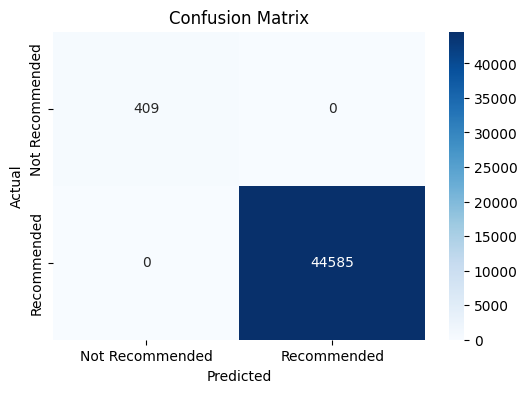

Accuracy: 1.00
Recall: 1.00
Precision: 1.00
F1 Score: 1.00
Specificity: 1.00


In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Recommended', 'Recommended'],
            yticklabels=['Not Recommended', 'Recommended'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Specificity
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Display metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Specificity: {specificity:.2f}')
